In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'
%reload_ext lab_black

In [2]:
import os
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy import signal
import pickle
from scipy.signal import hilbert
from ZilongCode.utils import bandpassfilter

In [4]:
datafolder = (
    "/home/zilong/Desktop/replay_trajectory_paper/Processed-Data/ThetaSweepTrajectories"
)

# load the classifier results
sweepresults = xr.open_dataset(
    os.path.join(datafolder, "bon_03_06_cv_classifier_clusterless_results.nc")
)

# load the data with pickle
with open(os.path.join(datafolder, "bon_03_06_data.pkl"), "rb") as f:
    data = pickle.load(f)

# get time slice
t = data["position_info"].index / np.timedelta64(1, "s")

Text(0.5, 1.0, 'LFP0 with zero phase marked')

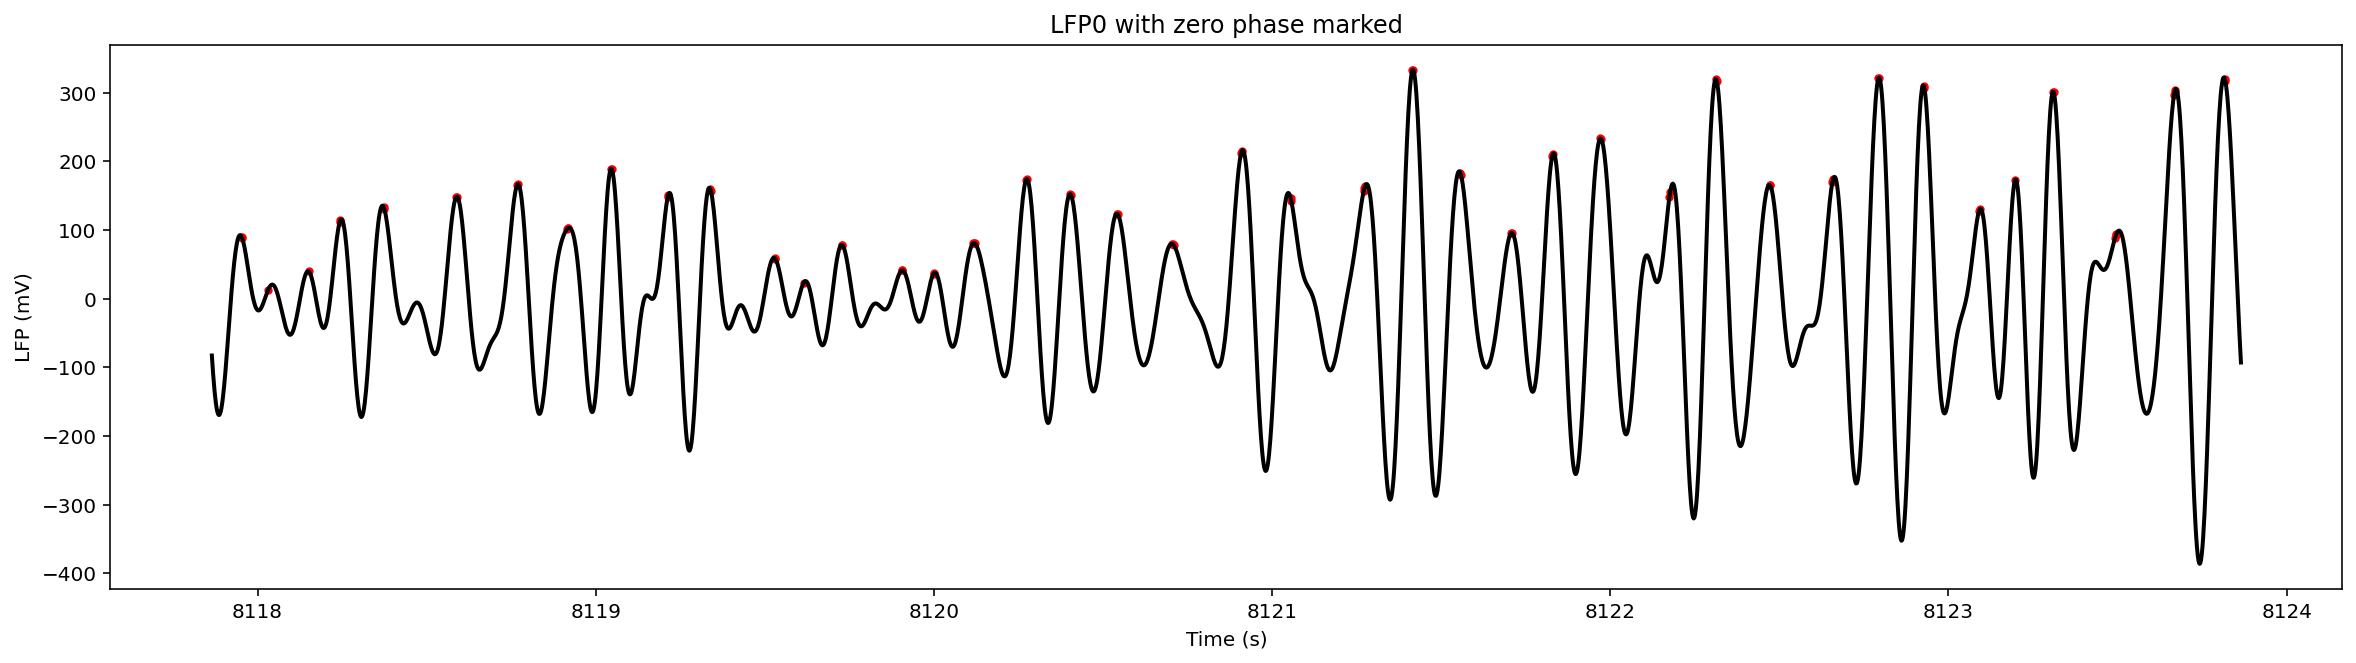

In [5]:
ind = 0
lfp = (
    data["lfps"]
    .reset_index(drop=True)
    .set_index(data["lfps"].index / np.timedelta64(1, "s"))
)
# add band passs filter to lfp.iloc[:,0], using band between 5-11Hz
lfp0 = bandpassfilter(lfp.iloc[:, ind], lowcut=5, highcut=11, fs=500)
# group the lfp0 into dataframe with time index
lfp0 = pd.DataFrame(lfp0, index=lfp.index)

time_slice = slice(t.min() + 360.85, t.min() + 366.85)

# find the zerp phase of lfp0 with hilbert transform

analytic_signal = hilbert(lfp0[time_slice].values.squeeze())
amplitude_envelope = np.abs(analytic_signal)
instantaneous_phase = np.unwrap(np.angle(analytic_signal))
instantaneous_frequency = np.diff(instantaneous_phase) / (2.0 * np.pi) * 500
# pad the instantaneous_frequency with 0
instantaneous_frequency = np.insert(instantaneous_frequency, 0, 0)
# wrap the instantaneous_phase to -pi and pi
instantaneous_phase = np.mod(instantaneous_phase + np.pi, 2 * np.pi) - np.pi
# find phase of 0 and mark all of them as a red point on the plot
zero_phase = np.where(
    np.logical_and(instantaneous_phase > -0.1, instantaneous_phase < 0.1)
)[0]

# plot
fig, ax = plt.subplots(figsize=(20, 5))
ax.plot(lfp.loc[time_slice].index.values, lfp0[time_slice], color="black", linewidth=2)
ax.scatter(
    lfp.loc[time_slice].index.values[zero_phase],
    lfp0[time_slice].values[zero_phase],
    color="red",
    s=10,
)
ax.set_ylabel("LFP (mV)")
ax.set_xlabel("Time (s)")
ax.set_title("LFP0 with zero phase marked")

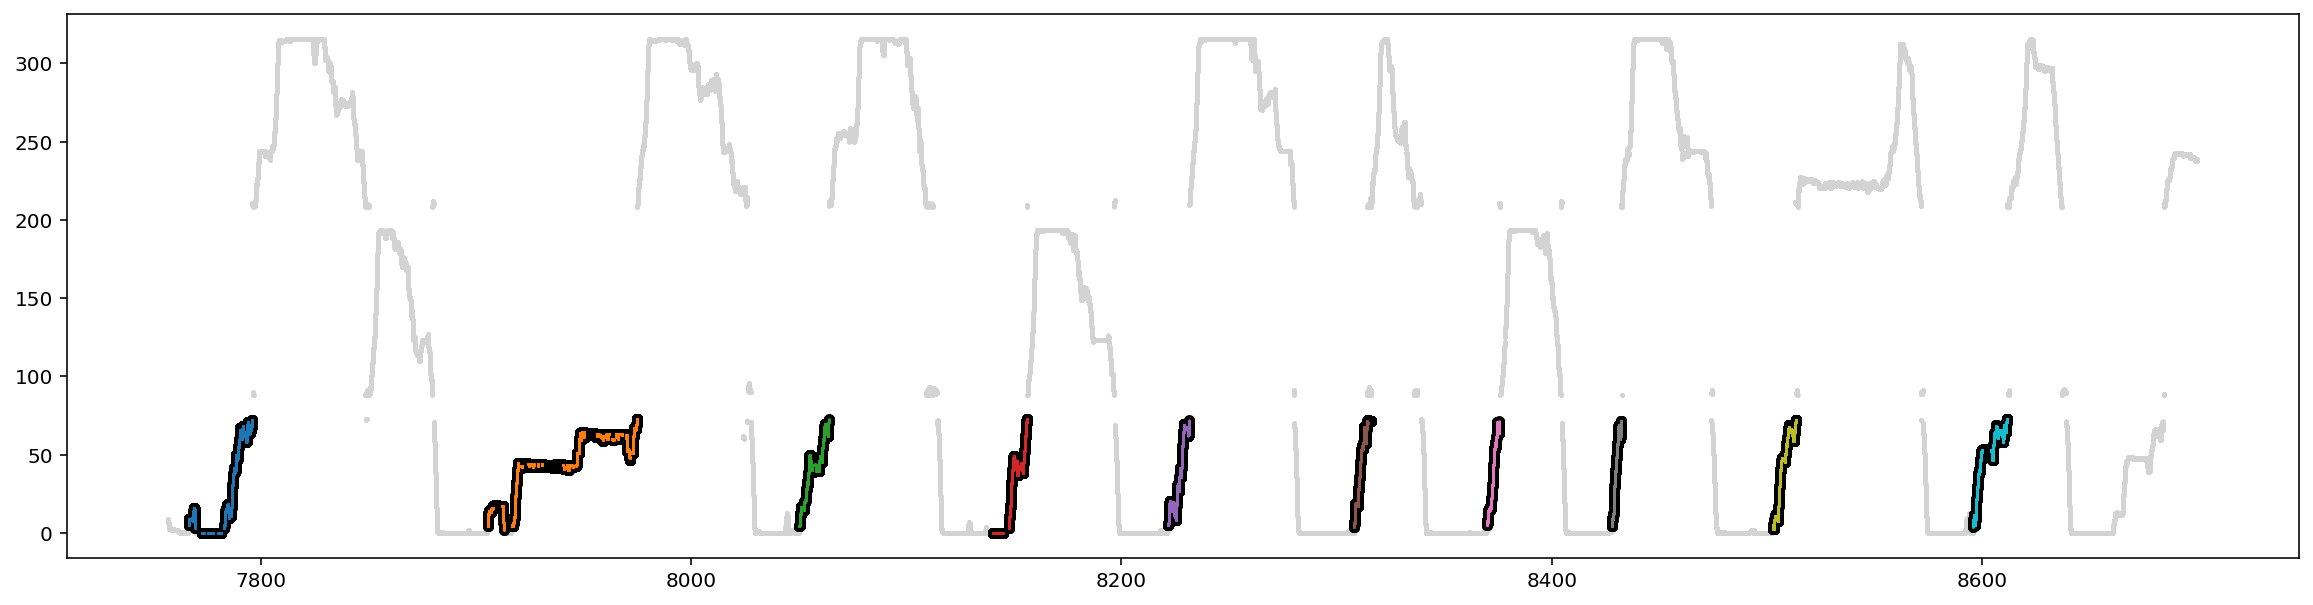

In [6]:
# extract position informtion
position_info = data["position_info"]

# extract position_info with only 'outbound' in task column, as well as 'Center Arm' in arm_name column

outbound_position_info = position_info[
    (position_info.task == "Outbound") & (position_info.arm_name == "Center Arm")
]

# select speed more than 10 cm/s in outbound_position_info
outbound_position_info_running = outbound_position_info[
    outbound_position_info.speed > 4
]

alltime = outbound_position_info_running.index / np.timedelta64(1, "s")
# split alltime into blocks if successive time difference is larger than 1s
alltime_split = np.split(alltime, np.where(np.diff(alltime) > 20)[0] + 1)

fig, ax = plt.subplots(figsize=(20, 5))

# plot all the position_info with very light grey dots
ax.scatter(
    position_info.index / np.timedelta64(1, "s"),
    position_info.linear_position,
    s=1,
    color="lightgrey",
)

# mark the outbound position with orange dots
ax.scatter(
    outbound_position_info.index / np.timedelta64(1, "s"),
    outbound_position_info.linear_position,
    s=20,
    c="black",
)

# for each block of alltime_split, plot the running outbound position with a different color
for i in range(len(alltime_split)):
    ax.scatter(
        alltime_split[i],
        outbound_position_info_running.reset_index()
        .set_index(alltime)
        .loc[alltime_split[i]]
        .linear_position,
        s=0.1,
    )

# #mark the running outbound position with lightblue dots
# ax.scatter(
#     outbound_position_info_running.index / np.timedelta64(1, "s"),
#     outbound_position_info_running.linear_position,
#     s=0.1,
#     c="lightblue",
# )

In [7]:
def get_zero_phase(filtered_lfp):
    """
    get the zero phase of the filtered lfp using hilbert transform
    """
    filtered_lfp = filtered_lfp.values.squeeze()
    analytic_signal = hilbert(filtered_lfp)
    instantaneous_phase = np.unwrap(np.angle(analytic_signal))
    # wrap the instantaneous_phase to -pi and pi
    instantaneous_phase = np.mod(instantaneous_phase + np.pi, 2 * np.pi) - np.pi
    # find phase of 0 and mark all of them as a red point on the plot
    zero_phase = np.where(
        np.logical_and(instantaneous_phase > -3.15, instantaneous_phase < -3.0)
    )[0]

    # if successive zero phase is less than 10, only keep the first one
    splits = np.split(zero_phase, np.where(np.diff(zero_phase) > 10)[0] + 1)
    zero_phase_index = np.array([split[0] for split in splits])

    return zero_phase_index

slice(8221.8428, 8231.4808, None)


Text(0.5, 1.0, 'LFP0 with zero phase marked')

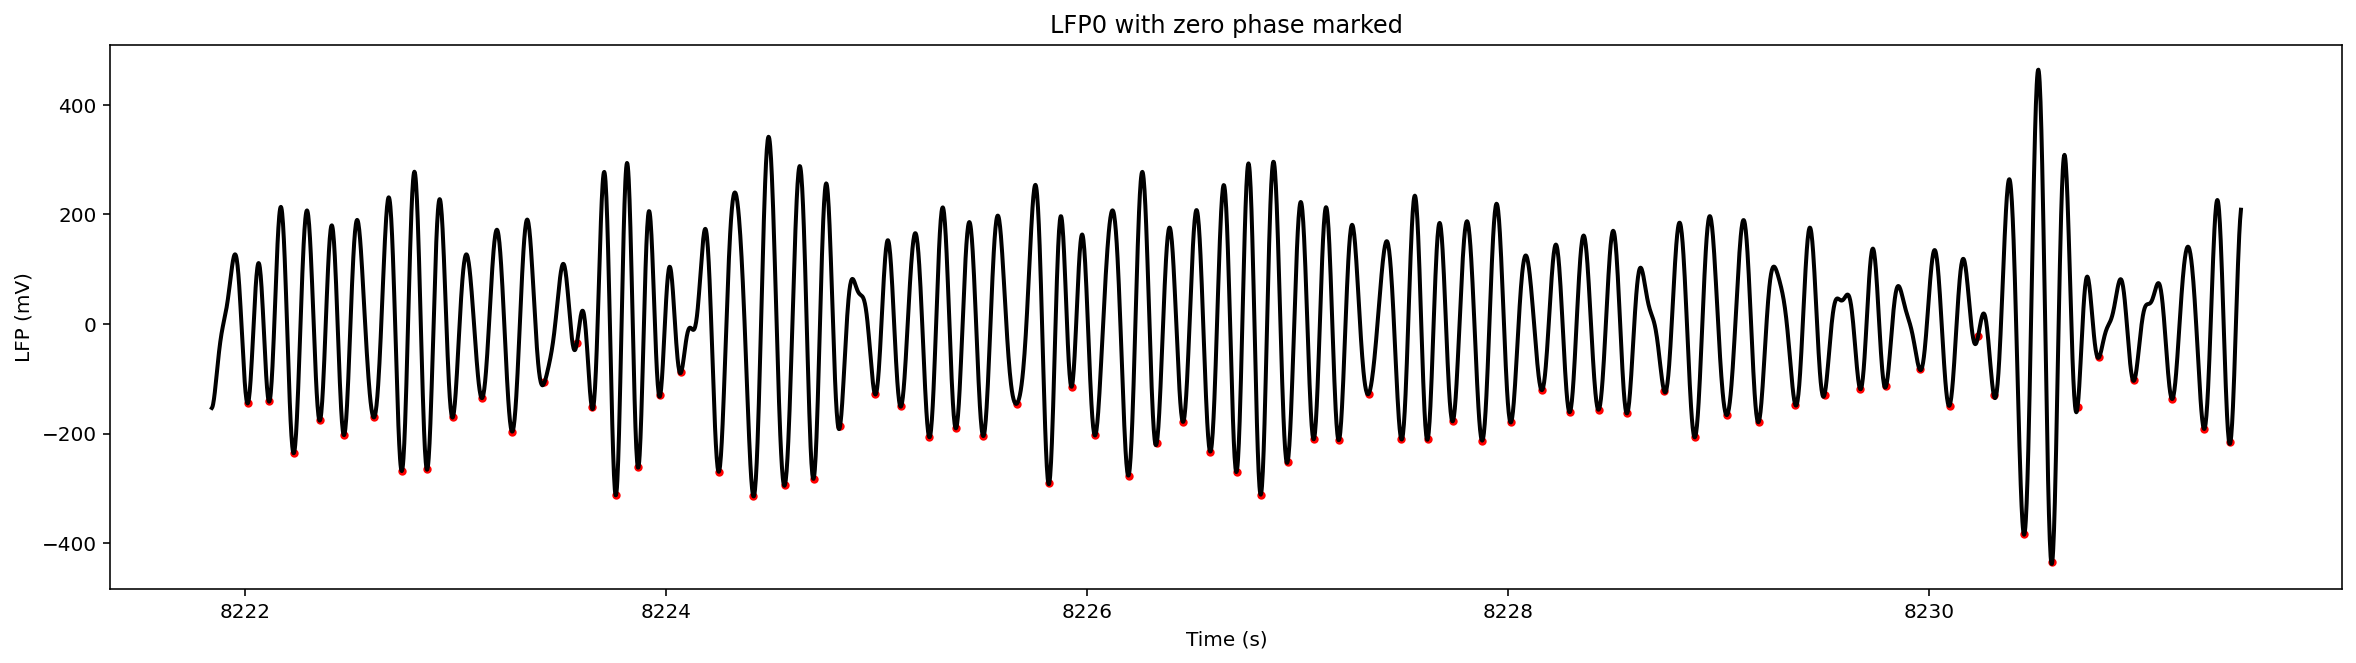

In [21]:
time_slice = slice(alltime_split[4][0], alltime_split[4][-1])
print(time_slice)

lfp_run_i = lfp0[time_slice]

zero_phase_index = get_zero_phase(lfp_run_i)


# plot the lfp0 with zero phase marked
fig, ax = plt.subplots(figsize=(20, 5))
ax.plot(lfp_run_i.index.values, lfp_run_i.values.squeeze(), color="black", linewidth=2)
ax.scatter(
    lfp_run_i.index.values[zero_phase_index],
    lfp_run_i.values.squeeze()[zero_phase_index],
    color="red",
    s=10,
)
ax.set_ylabel("LFP (mV)")
ax.set_xlabel("Time (s)")
ax.set_title("LFP0 with zero phase marked")

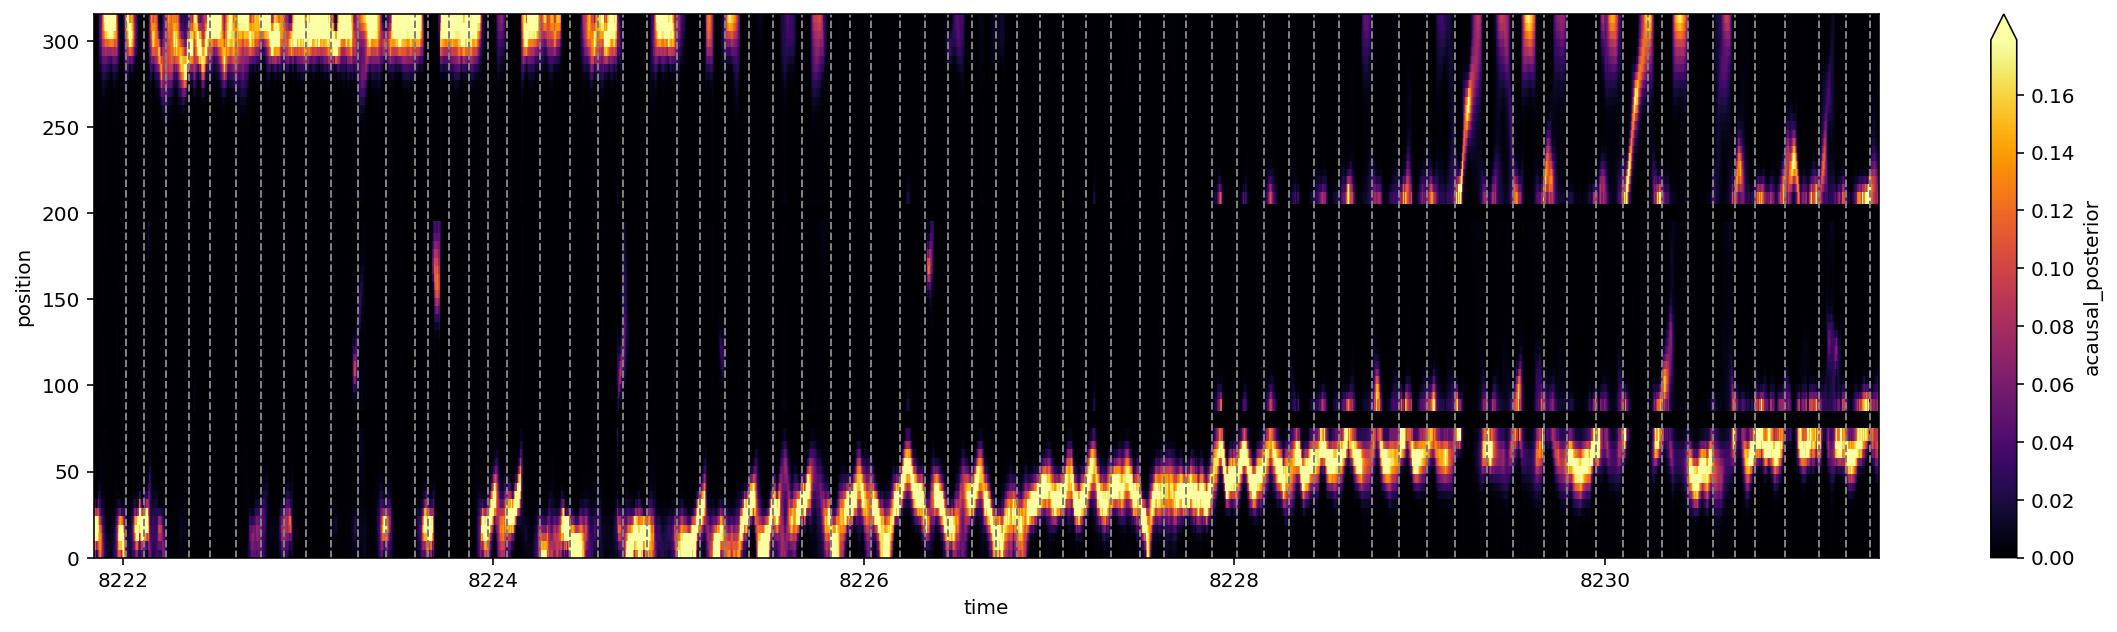

In [22]:
# get
fig, ax = plt.subplots(figsize=(20, 5))
sweepresults.acausal_posterior.sum("state").sel(time=time_slice).plot(
    x="time",
    y="position",
    robust=True,
    cmap="inferno",
    vmin=0.0,
)

# add vertical lines to mark the zero phase
for i in range(len(zero_phase_index)):
    ax.axvline(
        x=lfp_run_i.index.values[zero_phase_index[i]],
        color="grey",
        linestyle="--",
        linewidth=1,
    )

(175, 63)
(175, 63)
(175, 63)
(175, 63)
(175, 63)
(175, 63)
(175, 63)
(175, 63)
(175, 63)
(175, 63)
(175, 63)
(175, 63)
(175, 63)
(175, 63)
(175, 63)
(175, 63)
(175, 63)
(175, 63)
(175, 63)
(175, 63)
(175, 63)
(175, 63)
(175, 63)
(175, 63)
(175, 63)
(175, 63)
(175, 63)
(175, 63)
(175, 63)
(175, 63)
(175, 63)
(175, 63)
(175, 63)
(175, 63)
(175, 63)
(175, 63)
(175, 63)
(175, 63)
(175, 63)
(175, 63)
(175, 63)
(175, 63)
(175, 63)
(175, 63)
(175, 63)
(175, 63)


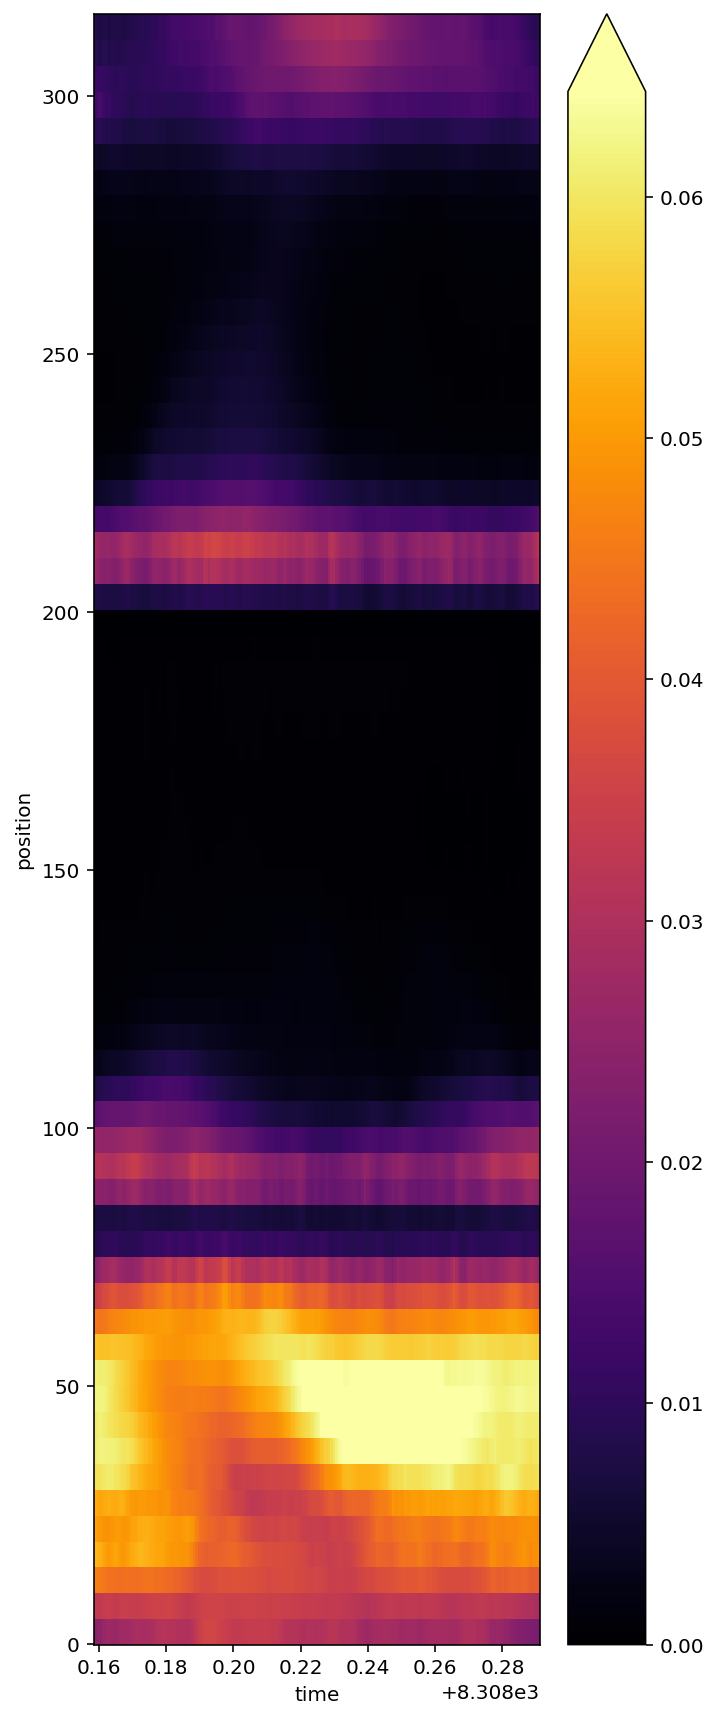

In [10]:
time_bins = lfp_run_i.index.values[zero_phase_index]

posterior_ = sweepresults.acausal_posterior.sum("state").sel(time=time_slice)

# get the poterior in each time bin
ALL_POSTERIOR = []
width = []
height = []
for i in range(len(time_bins) - 1):
    posterior_i = posterior_.sel(time=slice(time_bins[i], time_bins[i + 1]))
    width.append(posterior_i.shape[0])
    height.append(posterior_i.shape[1])
    ALL_POSTERIOR.append(posterior_i)

maxwidth = max(width)
maxheight = max(height)
# for each array in the ALL_POSTERIOR, interpolate it to the same size which is the maxwidth and maxheight
# do in a step by step way
ALL_POSTERIOR_INTERPOLATED = []
for i in range(len(ALL_POSTERIOR)):
    posterior_i = ALL_POSTERIOR[i]
    posterior_i = posterior_i.interp(
        time=np.linspace(posterior_i.time.min(), posterior_i.time.max(), maxwidth)
    )
    posterior_i = posterior_i.interp(
        position=np.linspace(
            posterior_i.position.min(), posterior_i.position.max(), maxheight
        )
    )
    ALL_POSTERIOR_INTERPOLATED.append(posterior_i)
    print(posterior_i.shape)

# average all the posterior and plot the mean posterior
mean_posterior = np.mean(
    np.stack([posterior_i.values for posterior_i in ALL_POSTERIOR_INTERPOLATED]), axis=0
)
mean_posterior = xr.DataArray(
    mean_posterior,
    coords=[ALL_POSTERIOR_INTERPOLATED[0].time, ALL_POSTERIOR_INTERPOLATED[0].position],
    dims=["time", "position"],
)
# plot with figsize=(5, 15)
mean_posterior.plot(
    x="time",
    y="position",
    robust=True,
    cmap="inferno",
    vmin=0.0,
    figsize=(5, 15),
)

In [10]:
def get_instantaneous_phase(filtered_lfp):
    """
    get the instantaneous phase of the filtered lfp using hilbert transform
    """
    filtered_lfp = filtered_lfp.values.squeeze()
    analytic_signal = hilbert(filtered_lfp)
    instantaneous_phase = np.unwrap(np.angle(analytic_signal))
    # wrap the instantaneous_phase to -pi and pi
    instantaneous_phase = np.mod(instantaneous_phase + np.pi, 2 * np.pi) - np.pi

    return instantaneous_phase

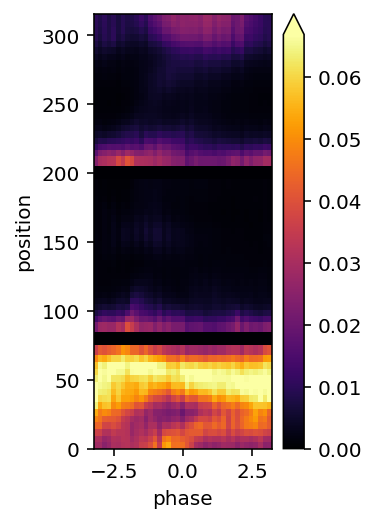

In [11]:
time_slice = slice(alltime_split[8][0], alltime_split[8][-1])
posterior_ = sweepresults.acausal_posterior.sum("state").sel(time=time_slice)

lfp_run_i = lfp0[time_slice]
phase = get_instantaneous_phase(lfp_run_i)

# group posterior_ by phase
# first get the phase bins
phase_bins = np.linspace(-np.pi, np.pi, 40)
# then for each phase_bin, get the posterior in that phase bin
ALL_POSTERIOR = []
for i in range(len(phase_bins) - 1):
    # get phases index belong to this phase bin
    phase_i_index = np.where((phase > phase_bins[i]) & (phase < phase_bins[i + 1]))[0]
    # select time_index according to phase_i index
    time_index = posterior_.time.values[phase_i_index]
    # select posterior according to time_index
    posterior_i = posterior_.sel(time=time_index)
    # average the posterior_i along time axis
    posterior_i = posterior_i.mean("time")
    ALL_POSTERIOR.append(posterior_i.values)

# change the ALL_POSTERIOR to   xr.DataArray
ALL_POSTERIOR = xr.DataArray(
    np.stack(ALL_POSTERIOR),
    coords=[np.linspace(-np.pi, np.pi, 39), posterior_.position],
    dims=["phase", "position"],
)

# plot the ALL_POSTERIOR
ALL_POSTERIOR.plot(
    x="phase",
    y="position",
    robust=True,
    cmap="inferno",
    vmin=0.0,
    figsize=(2, 4),
)

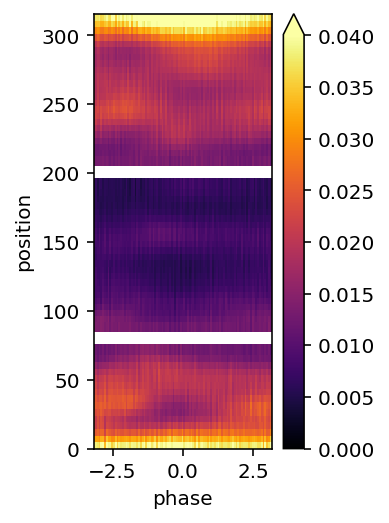

In [42]:
is_running = data["position_info"].speed > 10
t = data["position_info"].index / np.timedelta64(1, "s")
# get the position_info of running
posterior_ = sweepresults.acausal_posterior.sum("state", skipna=False).sel(
    time=data["position_info"].reset_index(drop=True).set_index(t).index[is_running]
)

is_running_time = (
    data["position_info"].reset_index(drop=True).set_index(t).index[is_running]
)

# get the linear_position from data["position_info"] with is_running ==True
linear_position = (
    data["position_info"]
    .reset_index(drop=True)
    .set_index(t)
    .linear_position.loc[is_running_time]
)

# get the lfp0 withis_running_time ==True
lfp_run_i = lfp0.loc[is_running_time]

phase = get_instantaneous_phase(lfp_run_i)

# group posterior_ by phase
# first get the phase bins
phase_bins = np.linspace(-np.pi, np.pi, 100)
# then for each phase_bin, get the posterior in that phase bin
ALL_POSTERIOR = []
for i in range(len(phase_bins) - 1):
    # get phases index belong to this phase bin
    phase_i_index = np.where((phase > phase_bins[i]) & (phase < phase_bins[i + 1]))[0]
    # select time_index according to phase_i index
    time_index = posterior_.time.values[phase_i_index]
    # select position according to phase_i index
    position_i = linear_position.values[phase_i_index]
    # select posterior according to time_index
    posterior_i_all = posterior_.sel(time=time_index)
    # average the posterior_i along time axis
    posterior_i = posterior_i_all.mean("time")
    ALL_POSTERIOR.append(posterior_i.values)

# change the ALL_POSTERIOR to xr.DataArray
ALL_POSTERIOR = xr.DataArray(
    np.stack(ALL_POSTERIOR),
    coords=[np.linspace(-np.pi, np.pi, 99), posterior_.position],
    dims=["phase", "position"],
)

# plot the ALL_POSTERIOR
ALL_POSTERIOR.plot(
    x="phase",
    y="position",
    robust=True,
    cmap="inferno",
    vmin=0.0,
    figsize=(2, 4),
)

In [99]:
def realign_posterior(posterior_i, position_bin_i, bins=31):
    """
    realign the posterior_i according to position_bin_i

    """

    # replace nan in posterior_i with 0
    posterior_i = np.nan_to_num(posterior_i)

    # First, initialize a new posterior with all zeros dim =31
    posterior_i_new = np.zeros((bins,))

    # Second, add dimension 39:63 to 15:39 in posterior_i, make a new posterior_i called posterior_i_wrap which has only 15+24 dimensions in total
    posterior_i_wrap = np.zeros((15 + 24,))
    posterior_i_wrap[:39] = posterior_i[:39]
    posterior_i_wrap[15:39] += posterior_i[39:63]

    # padding 15 zeros to two sides of posterior_i_wrap, make a new posterior_i_wrap_pad
    posterior_i_wrap_pad = np.pad(
        posterior_i_wrap, (15, 15), "constant", constant_values=(0, 0)
    )

    # crop the posterior_i_wrap_pad according with the center as position_bin_i+15, each side has 15 bins
    # and assign to posterior_i_new
    if position_bin_i >= 39:
        position_bin_i -= 24
    posterior_i_new = posterior_i_wrap_pad[position_bin_i : position_bin_i + 31]

    return posterior_i_new

In [102]:
is_running = data["position_info"].speed > 20

t = data["position_info"].index / np.timedelta64(1, "s")
# get the position_info of running
posterior_ = sweepresults.acausal_posterior.sum("state", skipna=False).sel(
    time=data["position_info"].reset_index(drop=True).set_index(t).index[is_running]
)

is_running_time = (
    data["position_info"].reset_index(drop=True).set_index(t).index[is_running]
)

# get the linear_position from data["position_info"] with is_running ==True
linear_position = (
    data["position_info"]
    .reset_index(drop=True)
    .set_index(t)
    .linear_position.loc[is_running_time]
)

# get the lfp0 withis_running_time ==True
lfp_run_i = lfp0.loc[is_running_time]

phase = get_instantaneous_phase(lfp_run_i)

phase_bins = np.linspace(-np.pi, np.pi, 100)
position_bins = posterior_.position

# basically, for each time point, we first get the posterior in that time point
# then figure out which position bin the current position belongs to
# then realign the posterior to the center of the position bin
# then we average the posteiors in each phase bin
# do it in for loop

all_posterior = np.zeros((31, 100))

for i in range(len(posterior_)):
    # print i if mod 10000
    if i % 10000 == 0:
        print(i)
    # get the posterior in this time point
    posterior_i = posterior_[i, :]
    # get the phase
    phase_i = phase[i]
    # get the phase bin it belongs to
    phase_bin_i = np.digitize(phase_i, phase_bins) - 1
    # get the position
    position_i = linear_position.values[i]
    # get the position bin it belongs to
    position_bin_i = np.digitize(position_i, position_bins) - 1
    if position_bin_i < 0 or position_bin_i > 62:
        continue
    # realign the posterior_i
    posterior_i_new = realign_posterior(posterior_i, position_bin_i)
    # add the posterior_i_new to all_posterior
    all_posterior[:, phase_bin_i] += posterior_i_new

0
10000
20000
30000


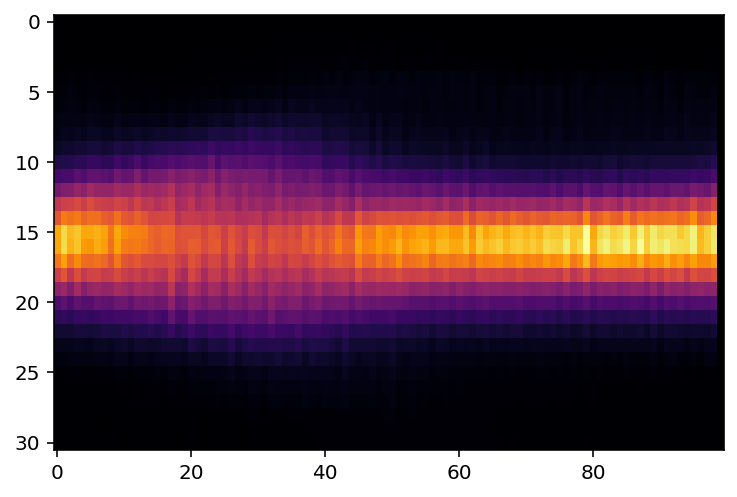

In [103]:
plt.imshow(all_posterior, aspect="auto", cmap="inferno", vmin=0.0)

In [96]:
all_posterior

array([[nan, nan, nan, ..., nan, nan,  0.],
       [nan, nan, nan, ..., nan, nan,  0.],
       [nan, nan, nan, ..., nan, nan,  0.],
       ...,
       [nan, nan, nan, ..., nan, nan,  0.],
       [nan, nan, nan, ..., nan, nan,  0.],
       [nan, nan, nan, ..., nan, nan,  0.]])